<a href="https://colab.research.google.com/github/udfds/DataLab/blob/master/exercises/365datascience/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Packages

In [13]:
!pip install pmdarima
!pip install arch
!pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [15]:
# https://finance.yahoo.com/quote/VOW3.DE
# https://finance.yahoo.com/quote/PAH3.DE
# https://finance.yahoo.com/quote/BMW.DE
raw_data = yfinance.download(tickers='VOW3.DE, PAH3.DE, BMW.DE', interval='1d', group_by='ticker', auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [0]:
df_business = raw_data.copy()

## Defining Key Dates

In [0]:
# Starting Date
start_date = '2009-04-05'

# First Official Announcement - 49.9%
announcement_1 = '2009-12-09'

# Second Official Announcement - 51.1%
announcement_2 = '2012-07-05'

#Ending Date
end_date = '2014-01-01'

# Dieselgate
# https://movolytics.co.uk/fleet-management-software/fuel-management/dieselgate-explained
dieselgate_date = '2015-09-20'

## Pre-processing the Data

In [18]:
# Extracting Closing Prices
df_business['vol'] = df_business['VOW3.DE'].Close
df_business['por'] = df_business['PAH3.DE'].Close
df_business['bmw'] = df_business['BMW.DE'].Close

# Creating Returns
df_business['returns_vol'] = df_business.vol.pct_change(1).mul(100)
df_business['returns_por'] = df_business.por.pct_change(1).mul(100)
df_business['returns_bmw'] = df_business.bmw.pct_change(1).mul(100)

# Creating Squared Returns (To examy the volatility)
df_business['squared_returns_vol'] = df_business.returns_vol.mul(df_business.returns_vol)
df_business['squared_returns_por'] = df_business.returns_por.mul(df_business.returns_por)
df_business['squared_returns_bmw'] = df_business.returns_bmw.mul(df_business.returns_bmw)

# Extracting Volume (The number of purchases and sales each day)
df_business['volume_vol'] = df_business['VOW3.DE'].Volume
df_business['volume_por'] = df_business['PAH3.DE'].Volume
df_business['volume_bmw'] = df_business['BMW.DE'].Volume

df_business.head()

VOW3.DE           ... volume_vol volume_por volume_bmw
              Open High Low  ...                                 
Date                         ...                                 
1996-11-08     NaN  NaN NaN  ...        NaN        NaN     767000
1996-11-11     NaN  NaN NaN  ...        NaN        NaN     260000
1996-11-12     NaN  NaN NaN  ...        NaN        NaN    1066000
1996-11-13     NaN  NaN NaN  ...        NaN        NaN     793000
1996-11-14     NaN  NaN NaN  ...        NaN        NaN     351000

[5 rows x 27 columns]

In [0]:
# Assigning the Frequency and Filling NA Values

# Frequency: Business days
df_business = df_business.asfreq('b')

# Fill: Backward fill
df_business = df_business.fillna(method='bfill')

In [0]:
# Removing Surplus Data
del df_business['VOW3.DE']
del df_business['PAH3.DE']
del df_business['BMW.DE']

## Plotting the Prices

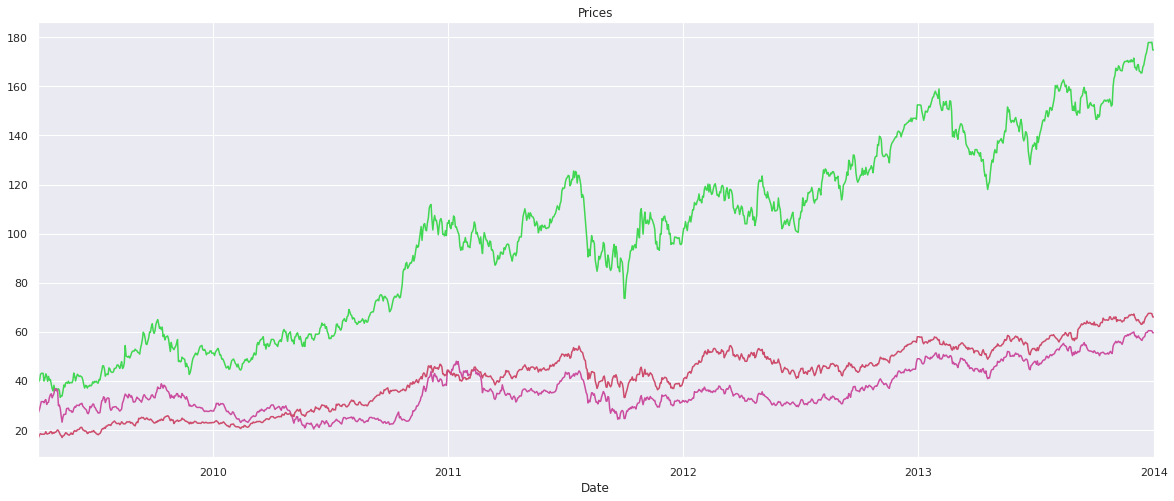

In [62]:
df_business.vol[start_date:end_date].plot(figsize=(20,8), color='#41d752')
df_business.por[start_date:end_date].plot(figsize=(20,8), color='#cb4d9f')
df_business.bmw[start_date:end_date].plot(figsize=(20,8), color='#cd4c6c')

plt.title('Prices');

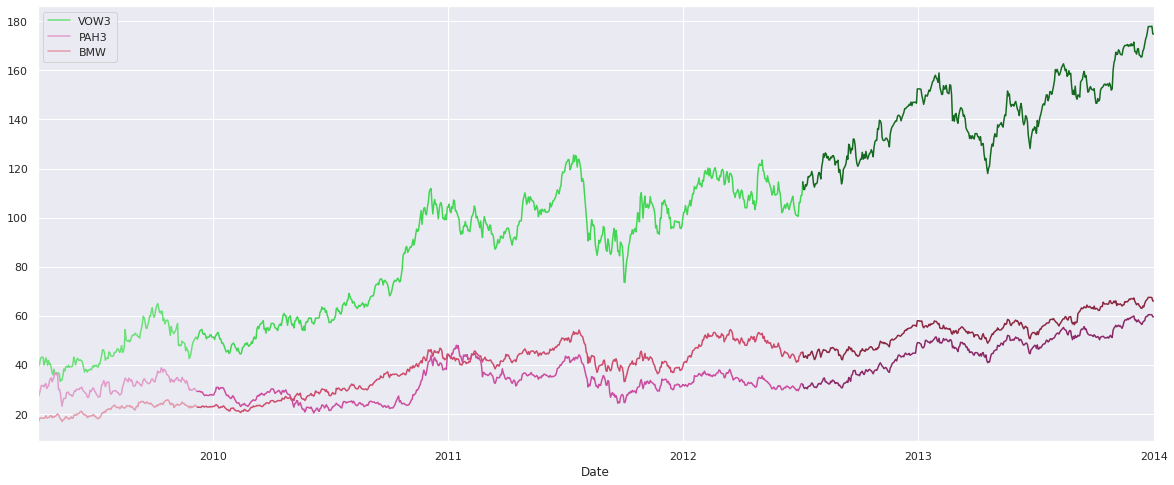

In [22]:
df_business.vol[start_date:announcement_1].plot(figsize=(20,8), color='#6ce078')
df_business.por[start_date:announcement_1].plot(figsize=(20,8), color='#e29cca')
df_business.bmw[start_date:announcement_1].plot(figsize=(20,8), color='#e39bad')

df_business.vol[announcement_1:announcement_2].plot(figsize=(20,8), color='#41d752')
df_business.por[announcement_1:announcement_2].plot(figsize=(20,8), color='#cb4d9f')
df_business.bmw[announcement_1:announcement_2].plot(figsize=(20,8), color='#cd4c6c')


df_business.vol[announcement_2:end_date].plot(figsize=(20,8), color='#166920')
df_business.por[announcement_2:end_date].plot(figsize=(20,8), color='#8a2868')
df_business.bmw[announcement_2:end_date].plot(figsize=(20,8), color='#8b2740')

plt.legend(['VOW3', 'PAH3', 'BMW'])

## Correlation

In [23]:
series_vol = df_business.vol[start_date:end_date]
series_por = df_business.por[start_date:end_date]
series_bmw = df_business.bmw[start_date:end_date]

print('Correlation among manufacturers from', start_date, 'to', end_date)
print('VOW3 and PAH3 correlation:\t', series_vol.corr(series_por))
print('VOW3 and BMW correlation:\t', series_vol.corr(series_bmw))
print('PAH3 and BMW correlation:\t', series_por.corr(series_bmw))

Correlation among manufacturers from 2009-04-05 to 2014-01-01
VOW3 and PAH3 correlation:	 0.8348049992443258
VOW3 and BMW correlation:	 0.9799384511501867
PAH3 and BMW correlation:	 0.8039398481425047


In [24]:
series_vol = df_business.vol[start_date:announcement_1]
series_por = df_business.por[start_date:announcement_1]
series_bmw = df_business.bmw[start_date:announcement_1]

print('Correlation among manufacturers from', start_date, 'to', announcement_1)
print('VOW3 and PAH3 correlation:\t', series_vol.corr(series_por))
print('VOW3 and BMW correlation:\t', series_vol.corr(series_bmw))
print('PAH3 and BMW correlation:\t', series_por.corr(series_bmw))

Correlation among manufacturers from 2009-04-05 to 2009-12-09
VOW3 and PAH3 correlation:	 0.6633400188255092
VOW3 and BMW correlation:	 0.8428353250592515
PAH3 and BMW correlation:	 0.6095045440130231


In [26]:
series_vol = df_business.vol[announcement_1:announcement_2]
series_por = df_business.por[announcement_1:announcement_2]
series_bmw = df_business.bmw[announcement_1:announcement_2]

print('Correlation among manufacturers from', announcement_1, 'to', announcement_2)
print('VOW3 and PAH3 correlation:\t', series_vol.corr(series_por))
print('VOW3 and BMW correlation:\t', series_vol.corr(series_bmw))
print('PAH3 and BMW correlation:\t', series_por.corr(series_bmw))

Correlation among manufacturers from 2009-12-09 to 2012-07-05
VOW3 and PAH3 correlation:	 0.742211441681872
VOW3 and BMW correlation:	 0.9795942983809952
PAH3 and BMW correlation:	 0.7035985466970395


In [27]:
series_vol = df_business.vol[announcement_2:end_date]
series_por = df_business.por[announcement_2:end_date]
series_bmw = df_business.bmw[announcement_2:end_date]

print('Correlation among manufacturers from', announcement_2, 'to', end_date)
print('VOW3 and PAH3 correlation:\t', series_vol.corr(series_por))
print('VOW3 and BMW correlation:\t', series_vol.corr(series_bmw))
print('PAH3 and BMW correlation:\t', series_por.corr(series_bmw))

Correlation among manufacturers from 2012-07-05 to 2014-01-01
VOW3 and PAH3 correlation:	 0.9405236820664735
VOW3 and BMW correlation:	 0.9284447102983764
PAH3 and BMW correlation:	 0.9494111676682194


In [28]:
series_vol = df_business.vol[end_date:]
series_por = df_business.por[end_date:]
series_bmw = df_business.bmw[end_date:]

print('Correlation among manufacturers from', end_date, 'to', df_business.index[-1])
print('VOW3 and PAH3 correlation:\t', series_vol.corr(series_por))
print('VOW3 and BMW correlation:\t', series_vol.corr(series_bmw))
print('PAH3 and BMW correlation:\t', series_por.corr(series_bmw))

Correlation among manufacturers from 2014-01-01 to 2020-04-03 00:00:00
VOW3 and PAH3 correlation:	 0.9463191361443708
VOW3 and BMW correlation:	 0.5255195456533001
PAH3 and BMW correlation:	 0.48918744892412525


## Best Fitting Models

### For Volkswagen

In [0]:
df_porbmw = df_business[['por', 'bmw']]

model_porbmw_ann1 = auto_arima(df_business.vol[start_date:announcement_1], 
                               exogenous=df_porbmw[start_date:announcement_1],
                               m=5, max_p=5, max_q=5)
model_porbmw_ann2 = auto_arima(df_business.vol[announcement_1:announcement_2], 
                               exogenous=df_porbmw[announcement_1:announcement_2],
                               m=5, max_p=5, max_q=5)
model_porbmw_end = auto_arima(df_business.vol[announcement_2:end_date], 
                              exogenous=df_porbmw[announcement_2:end_date],
                              m=5, max_p=5, max_q=5)

In [31]:
model_porbmw_ann1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -329.605
Date:                Sun, 05 Apr 2020   AIC                            669.210
Time:                        21:47:24   BIC                            685.119
Sample:                    04-06-2009   HQIC                           675.661
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7502      0.464      1.618      0.106      -0.159       1.659
por            0.3859      0.093      4.169      0.000       0.205       0.567
bmw            0.6494      0.308      2.108      0.035       0.045       1.253
ar.L1          0.9634      0.020     48.675      0.000       0.925       1.002
sigma2         2.3414      0.159     14.718      0.000       2.030       2.653
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_porbmw_ann2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1095.725
Date:                           Sun, 05 Apr 2020   AIC                           2207.450
Time:                                   21:48:21   BIC                           2243.520
Sample:                               12-09-2009   HQIC                          2221.420
                                    - 07-05-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      3.490      0.000       0.002       0.006
por            0.7633      0.060     12.828      0.000       0.647       0.880
bmw            1.4605      0.069     21.311      0.000       1.326       1.595
ar.L1          0.9440      0.015     62.654      0.000       0.914       0.974
ma.L1         -0.9995      0.061    -16.427      0.000      -1.119      -0.880
ar.S.L5       -0.9928      0.059    -16.712      0.000      -1.109      -0.876
ma.S.L5        0.9883      0.072     13.680      0.000       0.847       1.130
sigma2         1.5296      0.124     12.349      0.000       1.287       1.772
===================================================================================
Ljung-Box (Q):                       25.72   Jarque-Bera (JB):                90.02
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model_porbmw_end.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -622.244
Date:                Sun, 05 Apr 2020   AIC                           1250.488
Time:                        21:49:00   BIC                           1262.378
Sample:                    07-05-2012   HQIC                          1255.202
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6623      0.055     30.369      0.000       1.555       1.770
bmw            0.8046      0.086      9.381      0.000       0.637       0.973
sigma2         1.4352      0.070     20.461      0.000       1.298       1.573
===================================================================================
Ljung-Box (Q):                       28.08   Jarque-Bera (JB):               103.80
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [0]:
df_volbmw = df_business[['vol', 'bmw']]

model_volbmw_ann1 = auto_arima(df_business.por[start_date:announcement_1], 
                               exogenous=df_volbmw[start_date:announcement_1],
                               m=5, max_p=5, max_q=5)
model_volbmw_ann2 = auto_arima(df_business.por[announcement_1:announcement_2], 
                               exogenous=df_volbmw[announcement_1:announcement_2],
                               m=5, max_p=5, max_q=5)
model_volbmw_end = auto_arima(df_business.por[announcement_2:end_date], 
                              exogenous=df_volbmw[announcement_2:end_date],
                              m=5, max_p=5, max_q=5)

In [35]:
model_volbmw_ann1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -238.779
Date:                Sun, 05 Apr 2020   AIC                            489.558
Time:                        21:58:01   BIC                            508.649
Sample:                    04-06-2009   HQIC                           497.300
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6190      0.404      1.533      0.125      -0.173       1.411
vol            0.1192      0.055      2.157      0.031       0.011       0.227
bmw            0.8576      0.154      5.557      0.000       0.555       1.160
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.8468      0.060     14.098      0.000       0.729       0.964
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_volbmw_ann2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -629.007
Date:                Sun, 05 Apr 2020   AIC                           1268.013
Time:                        21:58:04   BIC                           1290.557
Sample:                    12-09-2009   HQIC                          1276.745
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0226      0.024     -0.938      0.348      -0.070       0.025
vol            0.1867      0.017     11.219      0.000       0.154       0.219
bmw            0.3148      0.045      7.022      0.000       0.227       0.403
ar.L1          0.0712      0.030      2.343      0.019       0.012       0.131
sigma2         0.3817      0.012     32.515      0.000       0.359       0.405
===================================================================================
Ljung-Box (Q):                       35.66   Jarque-Bera (JB):              1072.22
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_volbmw_end.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  390
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 5)   Log Likelihood                -236.012
Date:                           Sun, 05 Apr 2020   AIC                            484.023
Time:                                   21:58:06   BIC                            507.805
Sample:                               07-05-2012   HQIC                           493.451
                                    - 01-01-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0228      0.020      1.162      0.245      -0.016       0.061
vol            0.2302      0.014     16.410      0.000       0.203       0.258
bmw            0.2407      0.041      5.857      0.000       0.160       0.321
ma.L1         -0.0762      0.056     -1.373      0.170      -0.185       0.033
ma.S.L5       -0.1355      0.058     -2.337      0.019      -0.249      -0.022
sigma2         0.1970      0.008     25.906      0.000       0.182       0.212
===================================================================================
Ljung-Box (Q):                       33.69   Jarque-Bera (JB):               612.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

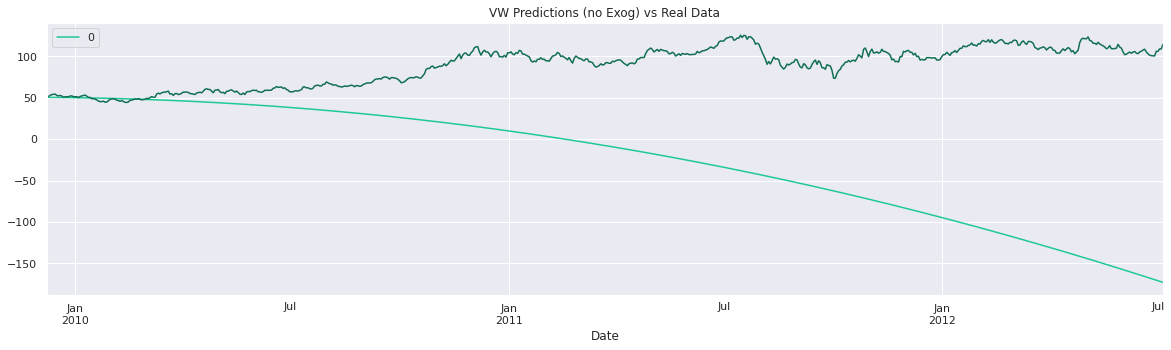

In [61]:
# Model, Series and Prediction
model_vol = auto_arima(df_business.vol[start_date:announcement_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')
series_announcement = df_business[announcement_1:announcement_2]
prediction = model_vol.predict(n_periods=len(series_announcement))

# New dataframe for the prediction
df_prediction = pd.DataFrame(prediction, index=series_announcement.index)

# Plotting the chart
df_prediction[announcement_1:announcement_2].plot(figsize=(20,5), color='#1dc996')
df_business.vol[announcement_1:announcement_2].plot(figsize=(20,5), color='#106f53')
plt.title('VW Predictions (no Exog) vs Real Data')
plt.show();

In [0]:
# It is very wrong

### For Volkswagen

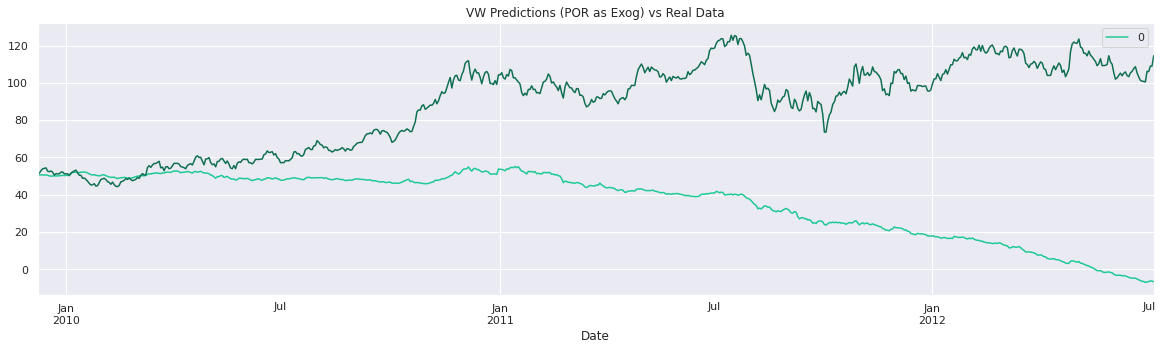

In [60]:
# Exogenous, Model, Series and Prediction
exogenous_model = df_business[['por']][start_date:announcement_1]
model_vol = auto_arima(df_business.vol[start_date:announcement_1],
                       exogenous=exogenous_model,
                       m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

exogenous_df = df_business[['por']][announcement_1:announcement_2]
series_announcement = df_business[announcement_1:announcement_2]
prediction = model_vol.predict(n_periods=len(series_announcement),exogenous=exogenous_df)

# New dataframe for the prediction
df_prediction = pd.DataFrame(prediction, index=series_announcement.index)

# Plotting the chart
df_prediction[announcement_1:announcement_2].plot(figsize=(20,5), color='#1dc996')
df_business.vol[announcement_1:announcement_2].plot(figsize=(20,5), color='#106f53')
plt.title('VW Predictions (POR as Exog) vs Real Data')
plt.show();

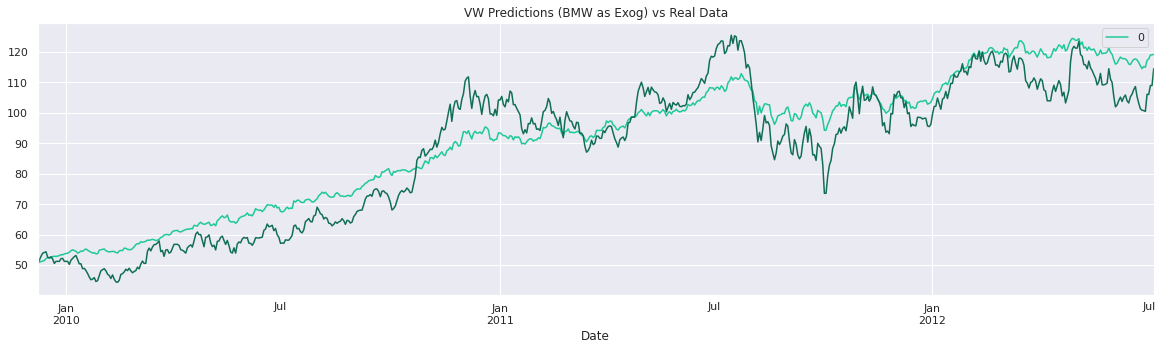

In [59]:
# Exogenous, Model, Series and Prediction
exogenous_model = df_business[['bmw']][start_date:announcement_1]
model_vol = auto_arima(df_business.vol[start_date:announcement_1],
                       exogenous=exogenous_model,
                       m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

exogenous_df = df_business[['bmw']][announcement_1:announcement_2]
series_announcement = df_business[announcement_1:announcement_2]
prediction = model_vol.predict(n_periods=len(series_announcement),exogenous=exogenous_df)

# New dataframe for the prediction
df_prediction = pd.DataFrame(prediction, index=series_announcement.index)

# Plotting the chart
df_prediction[announcement_1:announcement_2].plot(figsize=(20,5), color='#1dc996')
df_business.vol[announcement_1:announcement_2].plot(figsize=(20,5), color='#106f53')
plt.title('VW Predictions (BMW as Exog) vs Real Data')
plt.show();

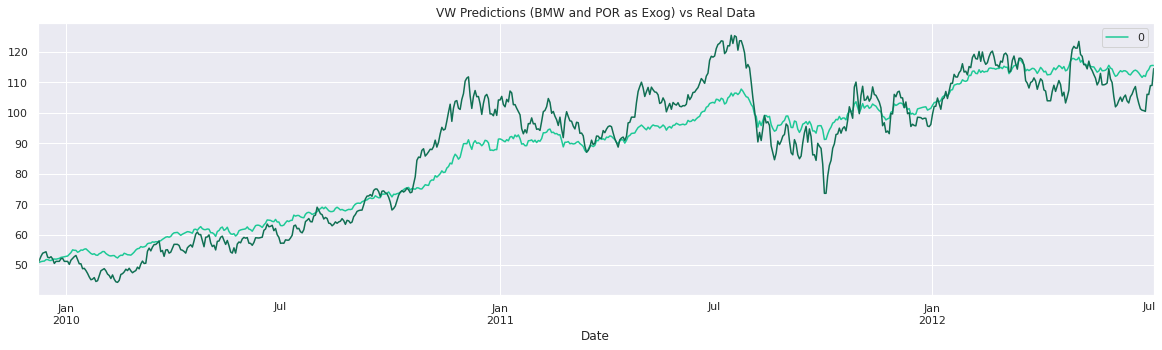

In [58]:
# Exogenous, Model, Series and Prediction
exogenous_model = df_business[['bmw', 'por']][start_date:announcement_1]
model_vol = auto_arima(df_business.vol[start_date:announcement_1],
                       exogenous=exogenous_model,
                       m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

exogenous_df = df_business[['bmw', 'por']][announcement_1:announcement_2]
series_announcement = df_business[announcement_1:announcement_2]
prediction = model_vol.predict(n_periods=len(series_announcement),exogenous=exogenous_df)

# New dataframe for the prediction
df_prediction = pd.DataFrame(prediction, index=series_announcement.index)

# Plotting the chart
df_prediction[announcement_1:announcement_2].plot(figsize=(20,5), color='#1dc996')
df_business.vol[announcement_1:announcement_2].plot(figsize=(20,5), color='#106f53')
plt.title('VW Predictions (BMW and POR as Exog) vs Real Data')
plt.show();

## Volatility

### Volatility of VW for Each Period

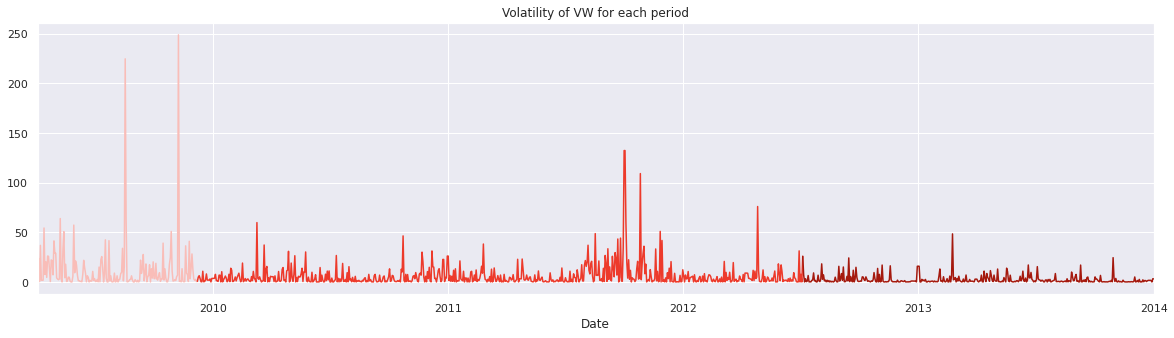

In [53]:
df_business['squared_returns_vol'][start_date:announcement_1].plot(figsize=(20,5), color='#f9bdb8')
df_business['squared_returns_vol'][announcement_1:announcement_2].plot(figsize=(20,5), color='#ed3a2b')
df_business['squared_returns_vol'][announcement_2:end_date].plot(figsize=(20,5), color='#a5190e')

plt.title('Volatility of VW for each period');

### Volatility Trends for Each Period

In [63]:
model_garch_1 = arch_model(df_business.vol[start_date:announcement_1], mean='Constant', vol='GARCH', p=1,q=1)
model_garch_2 = arch_model(df_business.vol[announcement_1:announcement_2], mean='Constant', vol='GARCH', p=1,q=1)
model_garch_3 = arch_model(df_business.vol[announcement_2:end_date], mean='Constant', vol='GARCH', p=1,q=1)

result_1 = model_garch_1.fit(update_freq=5)
result_2 = model_garch_2.fit(update_freq=5)
result_3 = model_garch_3.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 547.6233891583468
Iteration:     10,   Func. Count:     66,   Neg. LLF: 547.4045222030347
Iteration:     15,   Func. Count:     96,   Neg. LLF: 547.4042916783487
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 547.4042916092287
            Iterations: 15
            Function evaluations: 96
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2681.4484835729145
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2666.5510715725522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2666.1650117984345
            Iterations: 13
            Function evaluations: 83
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1478.3441653288583
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1465.228086650248
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1462.6990610502132

In [64]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.335
Mean Model:             Constant Mean   Adj. R-squared:                 -0.335
Vol Model:                      GARCH   Log-Likelihood:               -547.404
Distribution:                  Normal   AIC:                           1102.81
Method:            Maximum Likelihood   BIC:                           1115.54
                                        No. Observations:                  178
Date:                Sun, Apr 05 2020   Df Residuals:                      174
Time:                        23:31:58   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            42.1753      2.620     16.097  2.677e-58 [ 37.040, 47.310]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8225      1.187      1.535      0.125 [ -0.504,  4.149]
alpha[1]       0.9823      0.355      2.768  5.640e-03 [  0.287,  1.678]
beta[1]    5.0745e-17      0.302  1.678e-16      1.000 [ -0.593,  0.593]
========================================================================

Covariance estimator: robust
"""

In [65]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.418
Mean Model:             Constant Mean   Adj. R-squared:                 -0.418
Vol Model:                      GARCH   Log-Likelihood:               -2666.17
Distribution:                  Normal   AIC:                           5340.33
Method:            Maximum Likelihood   BIC:                           5358.37
                                        No. Observations:                  672
Date:                Sun, Apr 05 2020   Df Residuals:                      668
Time:                        23:31:58   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           103.0123      0.633    162.677      0.000 [1.018e+02,1.043e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.5755      1.518      3.014  2.581e-03 [  1.600,  7.551]
alpha[1]       0.9873      0.126      7.817  5.410e-15 [  0.740,  1.235]
beta[1]    1.1432e-15      0.125  9.179e-15      1.000 [ -0.244,  0.244]
========================================================================

Covariance estimator: robust
"""

In [66]:
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.052
Mean Model:             Constant Mean   Adj. R-squared:                 -0.052
Vol Model:                      GARCH   Log-Likelihood:               -1462.70
Distribution:                  Normal   AIC:                           2933.40
Method:            Maximum Likelihood   BIC:                           2949.26
                                        No. Observations:                  390
Date:                Sun, Apr 05 2020   Df Residuals:                      386
Time:                        23:31:58   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           146.5356      1.483     98.807      0.000 [1.436e+02,1.494e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.8571      1.883      2.048  4.055e-02 [  0.166,  7.548]
alpha[1]       0.9637      0.118      8.170  3.073e-16 [  0.733,  1.195]
beta[1]        0.0363  9.957e-02      0.364      0.716 [ -0.159,  0.231]
========================================================================

Covariance estimator: robust
"""